In [14]:
import pandas as pd
import numpy as np

from OptimalHedging.Heston import HestonSimulator

# -----------------------------
# 0) Parameters
# -----------------------------
M     = 1000
N     = 252
K     = 15.0
S0    = 10.0
T     = 1.0
t0    = 0.0
mu    = 0.05
sigma = 0.2

kappa   = 2.0
theta   = 0.2
sigma_v = 0.2
corr    = 0.7

gamma = 1.0
a     = 1.0
k     = 2.0
beta  = 0.95
U     = 10.0

np.random.seed(123)

t_idx = 0.2

# -----------------------------
# 1) Instantiate + simulate S, v and H
# -----------------------------
sim = HestonSimulator(
    M=M, N=N, K=K, S0=S0, T=T, t0=t0, mu=mu, sigma=sigma,
    kappa=kappa, theta=theta, sigma_v=sigma_v, corr=corr
)

sim.simulate_S()
sim.simulate_H(p_t=1, p_x=2, p_v=1, lam_ridge=1e-2)

# -----------------------------
# 2) Risks: kwargs
# -----------------------------
risk_specs = {
    "ele" : {"a": a},
    "elw" : {"k": k, "U": U},
    "entl": {"gamma": gamma, "U": U},
    "ente": {"gamma": gamma, "a": a, "U": U},
    "entw": {"gamma": gamma, "k": k, "U": U},
    "esl" : {"beta": beta},
}

eval_order = ["ele", "elw", "entl", "ente", "entw", "esl"]

# -----------------------------
# 3) Loop: compute MR
# -----------------------------
rows = []

for risk_type, risk_kwargs in risk_specs.items():
    MR, info = sim.compute_MR(
        t_idx=t_idx,
        risk_type=risk_type,
        risk_kwargs=risk_kwargs,
        max_iter=20,
        tol=1e-4,
        alpha=1e-1,
        verbose=False
    )

    rows.append({
        "Model": "Heston",
        "Risk": risk_type,
        "t_idx": t_idx,
        "MR": MR,
        "rho_T": info["rho_T"],
        "rho_t": info["rho_t"],
    })

df_MR = pd.DataFrame(rows)

# keep same column order as GBM test
df_MR["Risk"] = pd.Categorical(df_MR["Risk"], categories=eval_order, ordered=True)
df_MR = df_MR.sort_values("Risk").reset_index(drop=True)

pd.set_option("display.float_format", lambda x: f"{x:.6f}")
display(df_MR)


,Model,Risk,t_idx,MR,rho_T,rho_t
0,Heston,ele,0.200000,0.163931,1.000000,1.163931
1,Heston,elw,0.200000,0.258685,1.000000,1.258685
2,Heston,entl,0.200000,0.151818,0.000000,0.151818
3,Heston,ente,0.200000,0.559644,1.000000,1.559644
4,Heston,entw,0.200000,21.802409,1.000000,22.802409
5,Heston,esl,0.200000,1.017947,0.000000,1.017947


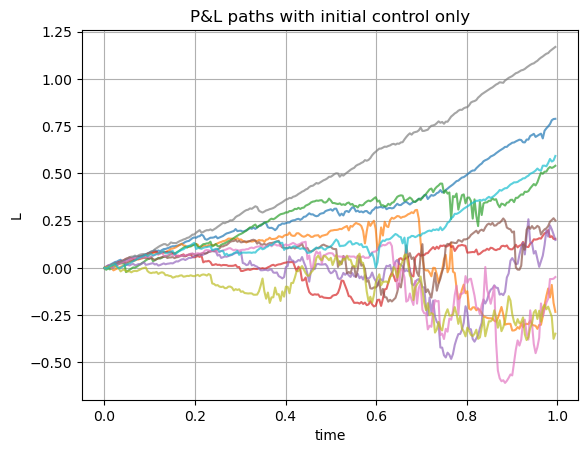

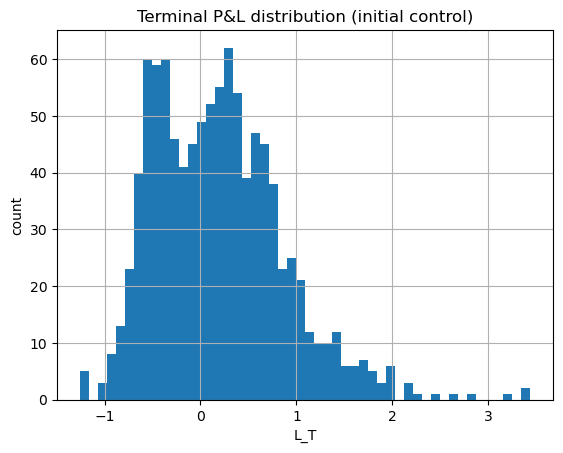

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from OptimalHedging.Heston import HestonSimulator

# -----------------------------
# Parameters
# -----------------------------
M     = 1000
N     = 252
K     = 12.0
S0    = 10.0
T     = 1.0
t0    = 0.0
mu    = 0.05
sigma = 0.2

kappa   = 1.0
theta   = 0.1
sigma_v = 0.1
corr    = 0.7

np.random.seed(123)

# -----------------------------
# Instantiate + simulate
# -----------------------------
sim = HestonSimulator(
    M=M, N=N, K=K, S0=S0, T=T, t0=t0, mu=mu, sigma=sigma,
    kappa=kappa, theta=theta, sigma_v=sigma_v, corr=corr
)

S, v = sim.simulate_S()
sim.simulate_H(p_t=1, p_x=2, p_v=1, lam_ridge=1e-2)

# -----------------------------
# Initial control only
# -----------------------------
h0 = sim.init_control(kind="Delta")

L = sim.forward_PL(h0, L0=0.0, t_start=0.0)
LT = L[:, -1]

t = t0 + sim.dt * np.arange(sim.steps)
idx = np.random.choice(M, size=10, replace=False)

# -----------------------------
# Plots
# -----------------------------

# P&L paths
plt.figure()
for i in idx:
    plt.plot(t, L[i], alpha=0.7)
plt.xlabel("time")
plt.ylabel("L")
plt.title("P&L paths with initial control only")
plt.grid(True)
plt.show()

# Terminal P&L histogram
plt.figure()
plt.hist(LT, bins=50)
plt.xlabel("L_T")
plt.ylabel("count")
plt.title("Terminal P&L distribution (initial control)")
plt.grid(True)
plt.show()
